In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

In [2]:
min_max_scaler = preprocessing.MinMaxScaler()

In [9]:
class MyDataset(Dataset):
 
    def __init__(self):
        df = pd.read_excel('/home/theo/Téléchargements/limagrain/Colza Résultats Antoine ZUBER-Juin 2017- BN18189_RESULTS_PROD.xlsx')

        mask  = (df['Fertilité grain']!='Donnée manquante') &\
                (df['Fertilité grain']!='perdue') &\
                (df['Fertilité grain']!='grain supplémentaire')

        x = df.iloc[:,8:-1][mask].values
        x = min_max_scaler.fit_transform(x)
        y = df[mask]['Fertilité grain'].values
        y = np.where(y=='Fertile', 0, 1)

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y,dtype=torch.float32)[:, None]
 
    def __len__(self):
        return len(self.y_train)
   
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

# Define the model

In [4]:
class LimagrainFC(nn.Module):
    def __init__(self):
        super(LimagrainFC, self).__init__()
        self.fc1 = nn.Linear(29, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fcout = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        
        output = self.fcout(x)
#        output = torch.sigmoid(output)
        
        return output

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, printout=False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0 and printout:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = 0
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            size += len(y)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred = torch.sigmoid(pred)
            target = torch.where(pred>0.5, 1, 0)
            correct += (target == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [16]:
model = LimagrainFC()

In [20]:
learning_rate = 5e-5
batch_size = 64
epochs = 500
validation_split = .2

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
d = MyDataset()

# Creating data indices for training and validation splits:
dataset_size = len(d)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(d, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(d, batch_size=batch_size,
                                                sampler=valid_sampler)

In [22]:
for t in range(epochs):
    if t%10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_loader, model, loss_fn, optimizer, printout=True)
        test_loop(validation_loader, model, loss_fn)
    else:
        train_loop(train_loader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.712479  [    0/ 3664]
Test Error: 
 Accuracy: 14.9%, Avg loss: 0.710539 

Epoch 11
-------------------------------
loss: 0.704163  [    0/ 3664]
Test Error: 
 Accuracy: 14.9%, Avg loss: 0.706686 

Epoch 21
-------------------------------
loss: 0.702601  [    0/ 3664]
Test Error: 
 Accuracy: 14.9%, Avg loss: 0.703107 

Epoch 31
-------------------------------
loss: 0.700797  [    0/ 3664]
Test Error: 
 Accuracy: 14.9%, Avg loss: 0.699416 

Epoch 41
-------------------------------
loss: 0.696381  [    0/ 3664]
Test Error: 
 Accuracy: 14.9%, Avg loss: 0.695952 

Epoch 51
-------------------------------
loss: 0.692807  [    0/ 3664]
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.692511 

Epoch 61
-------------------------------
loss: 0.689521  [    0/ 3664]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.689102 

Epoch 71
-------------------------------
loss: 0.685889  [    0/ 3664]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.685672 

Epoch 81
--------

KeyboardInterrupt: 

In [13]:
test_loop(train_loader, model, loss_fn)

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.515512 



# random forest

In [3]:
df = pd.read_excel('/home/thmegy/Téléchargements/Colza Résultats Antoine ZUBER-Juin 2017- BN18189_RESULTS_PROD.xlsx')

mask  = (df['Fertilité grain']!='Donnée manquante') &\
        (df['Fertilité grain']!='perdue') &\
        (df['Fertilité grain']!='grain supplémentaire')

X = df.iloc[:,8:-1][mask]
#X = min_max_scaler.fit_transform(X)
y = df[mask]['Fertilité grain']
y = np.where(y=='Fertile', 0, 1)


In [86]:
X.shape

(3664, 19)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [93]:
clf = RandomForestClassifier(n_estimators = 1000, class_weight='balanced') 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8354545454545454

In [94]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([1097,    3]))

In [95]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([922, 178]))

In [96]:
pos_ind = np.where(y_pred==1)
y_test[pos_ind]

array([0, 0, 0])

In [61]:
clf.predict_proba(X_test)[:20]

array([[0.685, 0.315],
       [0.936, 0.064],
       [0.876, 0.124],
       [0.939, 0.061],
       [0.67 , 0.33 ],
       [0.912, 0.088],
       [0.786, 0.214],
       [0.819, 0.181],
       [0.846, 0.154],
       [0.804, 0.196],
       [0.881, 0.119],
       [0.889, 0.111],
       [0.89 , 0.11 ],
       [0.869, 0.131],
       [0.874, 0.126],
       [0.829, 0.171],
       [0.907, 0.093],
       [0.877, 0.123],
       [0.897, 0.103],
       [0.873, 0.127]])

# logistic regression

In [62]:
from sklearn.linear_model import LogisticRegression

In [65]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

/home/thmegy/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.835820895522388

In [66]:
pos_ind = np.where(y_pred==1)
y_test[pos_ind]

array([0, 0, 1])

# clustering

In [4]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
for c in X.columns:
    X[c] = (X[c] - X[c].mean()) / X[c].std()

In [10]:
pca = PCA()
pca.fit(X)
new_feats = pca.transform(X)

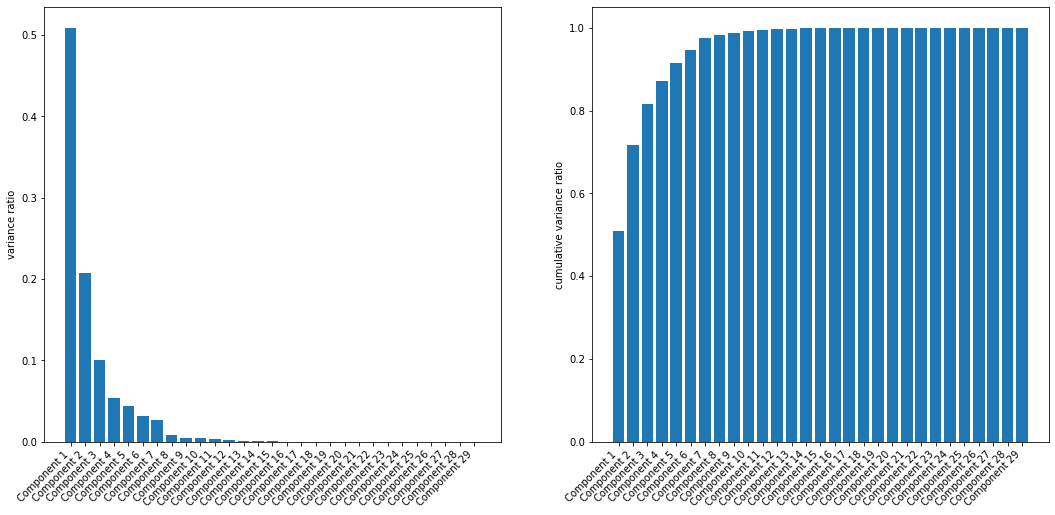

In [11]:
plt.figure(figsize=(18,8))

plt.subplot(1 ,2, 1)
var_ratio = pca.explained_variance_ratio_
plt.bar( range(len(var_ratio)), var_ratio )
plt.ylabel('variance ratio')
ticks = plt.xticks(ticks=[i for i in range(len(var_ratio))],
           labels=['Component {}'.format(i+1) for i in range(len(var_ratio))], rotation=45, ha='right')

plt.subplot(1 ,2, 2)
plt.bar( range(len(var_ratio)), np.cumsum(var_ratio) )
plt.ylabel('cumulative variance ratio')
ticks = plt.xticks(ticks=[i for i in range(len(var_ratio))],
           labels=['Component {}'.format(i+1) for i in range(len(var_ratio))], rotation=45, ha='right')

In [15]:
def drawCorrCircle(df_trans, df_orig, cols):
    df_trans = df_trans.iloc[:,cols]
    df_concat = pd.concat([df_orig, df_trans], axis=1)
    corrmat = df_concat.corr()
    plt.rcParams['figure.figsize'] = (10, 10)

    theta = np.arange(-np.pi, np.pi, 0.05)
    x = np.cos(theta)
    y = np.sin(theta)
    plt.plot(x, y)

    for f in range(16):
        plt.plot( [0,corrmat.iloc[f,-2]], [0,corrmat.iloc[f,-1]] )

    plt.xlabel('Component {}'.format(cols[0]+1))
    plt.ylabel('Component {}'.format(cols[1]+1))

#    for i, name in enumerate(corrmat.iloc[:,:-2].columns):
#        plt.annotate(name, (corrmat.iloc[i,-2], corrmat.iloc[i,-1]))
        
df_pca = pd.DataFrame(new_feats, columns = ['component {}'.format(i+1) for i in range(new_feats.shape[1])])

plt.figure(figsize=(15,13))

plt.subplot(2, 2, 1)
drawCorrCircle(df_pca, X, [0,1])

plt.subplot(2, 2, 2)
drawCorrCircle(df_pca, X, [0,2])

plt.subplot(2, 2, 3)
drawCorrCircle(df_pca, X, [0,3])

plt.tight_layout()

NameError: name 'new_feats' is not defined

(array([ 14.,  97., 499., 975., 842., 448., 237., 125., 106.,  86.,  63.,
         63.,  42.,  27.,  16.,   3.,  10.,   4.,   1.,   0.,   1.,   1.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-6.99717953e+00, -5.58947158e+00, -4.18176362e+00, -2.77405567e+00,
        -1.36634772e+00,  4.13602334e-02,  1.44906819e+00,  2.85677614e+00,
         4.26448409e+00,  5.67219204e+00,  7.07989999e+00,  8.48760795e+00,
         9.89531590e+00,  1.13030239e+01,  1.27107318e+01,  1.41184398e+01,
         1.55261477e+01,  1.69338557e+01,  1.83415636e+01,  1.97492716e+01,
         2.11569795e+01,  2.25646875e+01,  2.39723954e+01,  2.53801034e+01,
         2.67878113e+01,  2.81955193e+01,  2.96032272e+01,  3.10109352e+01,
         3.24186431e+01,  3.38263511e+01,  3.52340590e+01,  3.66417670e+01,
         3.80494749e+01,  3.94571829e+01,  4.08648908e+01,  4.22725988e+01,
         4.36803068e+01,  4.50880147e+01, 

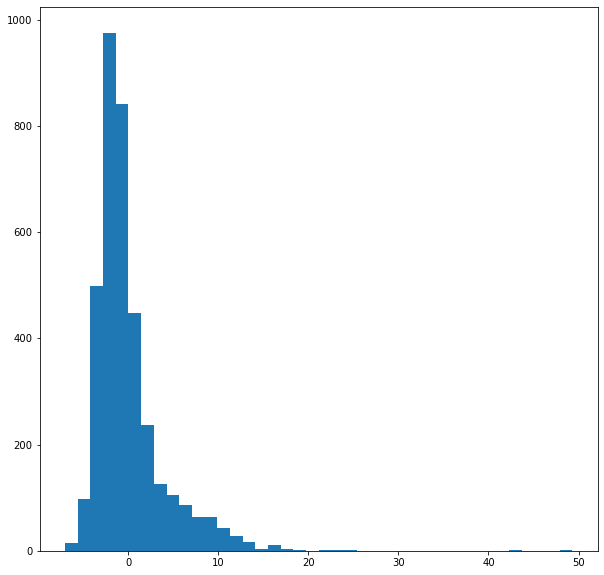

In [13]:
plt.hist(new_feats[:,0], bins=40)

In [14]:
(new_feats[:,0] < -25).sum()

0

In [15]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3057,  607]))

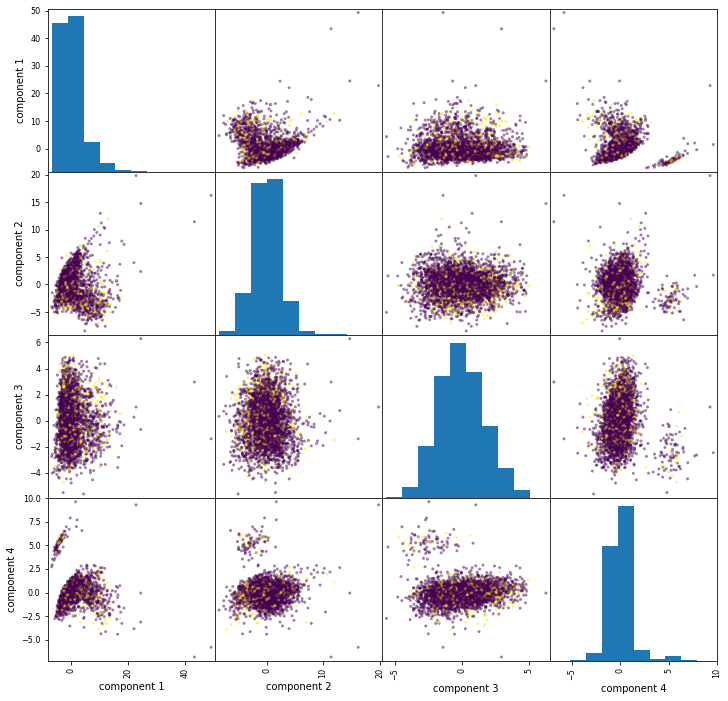

In [16]:
scatter = pd.plotting.scatter_matrix(df_pca.iloc[:,:4], figsize=(12, 12), c=y)

In [102]:
X.std() / X.mean()

Area (mm2)             0.170443
Length (mm)            0.086386
Width (mm)             0.092569
Roundness              0.064048
CIELab L*              0.119471
CIELab A*              2.454949
CIELab B*             -4.737428
Intensity              0.173664
Hue                    0.216053
Saturation             1.151010
MultiColorMean1[0]     0.112880
MultiColorMean1[1]     0.088418
MultiColorMean1[2]     0.100698
MultiColorMean1[3]     0.107761
MultiColorMean1[4]     0.110066
MultiColorMean1[5]     0.216131
MultiColorMean1[6]     0.166553
MultiColorMean1[7]     0.288672
MultiColorMean1[8]     0.284065
MultiColorMean1[9]     0.312042
MultiColorMean1[10]    0.310820
MultiColorMean1[11]    0.298738
MultiColorMean1[12]    0.388079
MultiColorMean1[13]    0.379142
MultiColorMean1[14]    0.210666
MultiColorMean1[15]    0.165143
MultiColorMean1[16]    0.132720
MultiColorMean1[17]    0.085575
MultiColorMean1[18]    0.063890
dtype: float64

## Dimensionality reduction

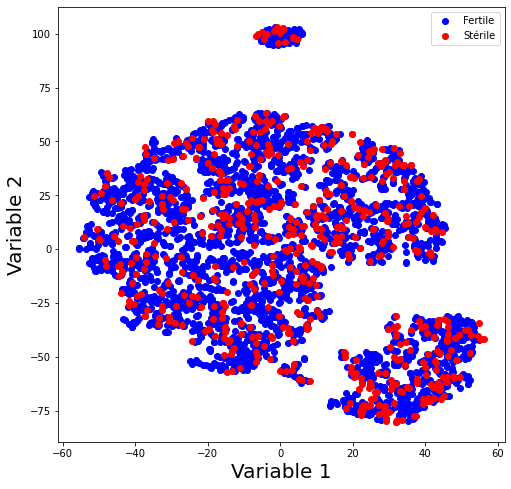

In [8]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

plt.figure(figsize=(8,8))
plt.scatter(X_embedded[:,0][y==0], X_embedded[:,1][y==0], c='blue', label='Fertile')
plt.scatter(X_embedded[:,0][y==1], X_embedded[:,1][y==1], c='red', label='Stérile')
plt.xlabel('Variable 1', fontsize=20)
plt.ylabel('Variable 2', fontsize=20)
plt.legend()
plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/tsne_fertile_sterile.png')

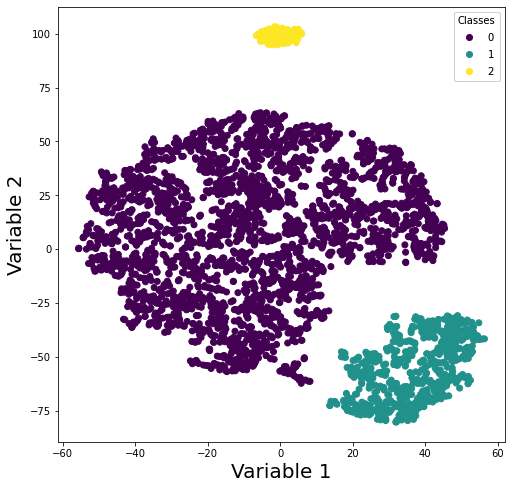

In [10]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=5, min_samples=10).fit(X_embedded)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/tsne_dbscan.png')

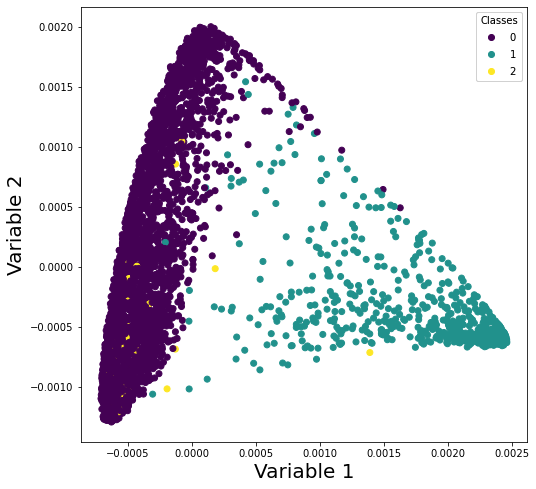

In [11]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X)

#clustering = SpectralClustering(n_clusters=2,
#        assign_labels='discretize',
#        random_state=0).fit(X_transformed)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/spectral_tsne_dbscan.png')

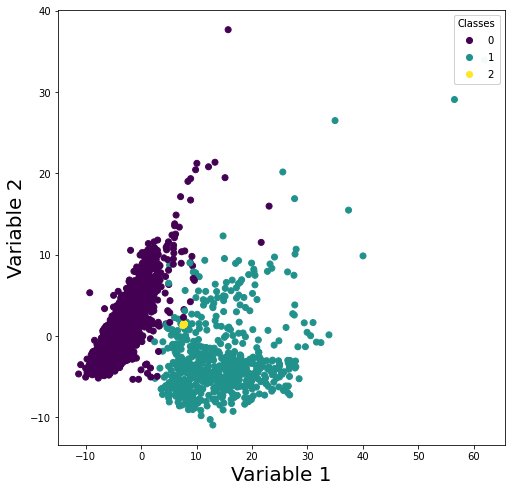

In [12]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X)

fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(X_transformed[:,0], X_transformed[:,1], c=clustering.labels_)
#plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)
ax.set_xlabel('Variable 1', fontsize=20)
ax.set_ylabel('Variable 2', fontsize=20)
plt.savefig('/home/thmegy/Documents/reports/Images/limagrain/isomap_tsne_dbscan.png')

In [13]:
np.unique(clustering.labels_, return_counts=True)

(array([0, 1, 2]), array([2922,  651,   91]))

In [14]:
df[mask][clustering.labels_ == 1].iloc[:,8:-1].mean() - df[mask][clustering.labels_ == 0].iloc[:,8:-1].mean()

Area (mm2)             -0.037149
Length (mm)            -0.024216
Width (mm)             -0.014829
Roundness              -0.019728
CIELab L*               4.539122
CIELab A*               6.583250
CIELab B*               7.801448
Intensity               1.612265
Hue                   -56.189505
Saturation              2.687701
MultiColorMean1[0]      1.170450
MultiColorMean1[1]      0.028527
MultiColorMean1[2]      0.017902
MultiColorMean1[3]     -0.018022
MultiColorMean1[4]     -0.015811
MultiColorMean1[5]      0.333422
MultiColorMean1[6]      0.699483
MultiColorMean1[7]      2.141724
MultiColorMean1[8]      2.966312
MultiColorMean1[9]      4.155334
MultiColorMean1[10]     4.260036
MultiColorMean1[11]     4.320037
MultiColorMean1[12]     8.286972
MultiColorMean1[13]    14.764888
MultiColorMean1[14]    15.696439
MultiColorMean1[15]    14.181849
MultiColorMean1[16]    12.345117
MultiColorMean1[17]     8.381203
MultiColorMean1[18]     6.014767
dtype: float64

In [15]:
df[mask][clustering.labels_ == 1].iloc[:,18:-1].mean()

MultiColorMean1[0]      8.908545
MultiColorMean1[1]      7.013766
MultiColorMean1[2]      7.086248
MultiColorMean1[3]      6.962510
MultiColorMean1[4]      6.990534
MultiColorMean1[5]      6.952237
MultiColorMean1[6]      7.100224
MultiColorMean1[7]      8.326052
MultiColorMean1[8]      8.802603
MultiColorMean1[9]     10.410034
MultiColorMean1[10]    10.625565
MultiColorMean1[11]    11.053612
MultiColorMean1[12]    16.622336
MultiColorMean1[13]    31.960936
MultiColorMean1[14]    47.460580
MultiColorMean1[15]    52.538417
MultiColorMean1[16]    56.126060
MultiColorMean1[17]    61.845259
MultiColorMean1[18]    66.117382
dtype: float64

In [16]:
df[mask][clustering.labels_ == 0].iloc[:,18:-1].mean()

MultiColorMean1[0]      7.738095
MultiColorMean1[1]      6.985240
MultiColorMean1[2]      7.068346
MultiColorMean1[3]      6.980532
MultiColorMean1[4]      7.006344
MultiColorMean1[5]      6.618815
MultiColorMean1[6]      6.400741
MultiColorMean1[7]      6.184328
MultiColorMean1[8]      5.836291
MultiColorMean1[9]      6.254700
MultiColorMean1[10]     6.365529
MultiColorMean1[11]     6.733575
MultiColorMean1[12]     8.335364
MultiColorMean1[13]    17.196049
MultiColorMean1[14]    31.764141
MultiColorMean1[15]    38.356569
MultiColorMean1[16]    43.780943
MultiColorMean1[17]    53.464055
MultiColorMean1[18]    60.102616
dtype: float64

In [23]:
from sklearn.cluster import SpectralClustering
clustering = SpectralClustering(n_clusters=3,
        assign_labels='discretize',
        random_state=0).fit(X_embedded)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=clustering.labels_)

/home/thmegy/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [19]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
new_df = df[mask].copy()

In [31]:
new_df['Cluster'] = clustering.labels_

In [34]:
new_df.to_excel('graines_avec_clusters.xlsx')

In [6]:
df = pd.read_excel('/home/thmegy/Documents/reports/graines_avec_clusters.xlsx', index_col=0)

In [9]:
df[df['Cluster'] == 1].iloc[:,8:-1].mean()

Area (mm2)               3.945044
Length (mm)              2.378145
Width (mm)               2.189121
Roundness                1.856151
CIELab L*               32.090022
CIELab A*                6.634163
CIELab B*                5.748230
Intensity                8.157589
Hue                    116.414346
Saturation               3.465772
MultiColorMean1[0]       8.908545
MultiColorMean1[1]       7.013766
MultiColorMean1[2]       7.086248
MultiColorMean1[3]       6.962510
MultiColorMean1[4]       6.990534
MultiColorMean1[5]       6.952237
MultiColorMean1[6]       7.100224
MultiColorMean1[7]       8.326052
MultiColorMean1[8]       8.802603
MultiColorMean1[9]      10.410034
MultiColorMean1[10]     10.625565
MultiColorMean1[11]     11.053612
MultiColorMean1[12]     16.622336
MultiColorMean1[13]     31.960936
MultiColorMean1[14]     47.460580
MultiColorMean1[15]     52.538417
MultiColorMean1[16]     56.126060
MultiColorMean1[17]     61.845259
MultiColorMean1[18]     66.117382
Org. Filename 

In [10]:
df[df['Cluster'] == 0].iloc[:,8:-1].mean()

Area (mm2)               3.982193
Length (mm)              2.402361
Width (mm)               2.203951
Roundness                1.875879
CIELab L*               27.550899
CIELab A*                0.050912
CIELab B*               -2.053218
Intensity                6.545325
Hue                    172.603852
Saturation               0.778071
MultiColorMean1[0]       7.738095
MultiColorMean1[1]       6.985240
MultiColorMean1[2]       7.068346
MultiColorMean1[3]       6.980532
MultiColorMean1[4]       7.006344
MultiColorMean1[5]       6.618815
MultiColorMean1[6]       6.400741
MultiColorMean1[7]       6.184328
MultiColorMean1[8]       5.836291
MultiColorMean1[9]       6.254700
MultiColorMean1[10]      6.365529
MultiColorMean1[11]      6.733575
MultiColorMean1[12]      8.335364
MultiColorMean1[13]     17.196049
MultiColorMean1[14]     31.764141
MultiColorMean1[15]     38.356569
MultiColorMean1[16]     43.780943
MultiColorMean1[17]     53.464055
MultiColorMean1[18]     60.102616
Org. Filename 